In [1]:
# Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score
from sklearn.utils import parallel_backend
from pyearth import Earth
from patsy import dmatrix
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
import warnings
from pyearth import Earth
from sklearn.model_selection import RandomizedSearchCV, KFold


In [3]:
# Loading data
X_test = pd.read_csv('data/X_test.csv')
X_train = pd.read_csv('data/X_train.csv')
y_test = pd.read_csv('data/y_test.csv')
y_train = pd.read_csv('data/y_train.csv')

### Coarse Grid Hyperparameter Optimization

In [4]:
# Coarse grid search for hyperparameter optimization
    # Note: I fit 25 models here and it took approximately an hour and a half (90 mins)

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning)
init_search_df = pd.DataFrame(columns = ['degree', 'max_terms', 'rmse'])


# Lists to store the values for plotting
degrees = []
max_terms_values = []
mean_scores = []

# Initializing optimal parameters & best score variables
opt_degree = 1
opt_max_terms = 500
best_score = -float('inf')

# Outer loop for degree
for degree in range(1, 11, 2):
    print('Fitting models for degree = ', degree)

    # Creating a MARS model with the current degree and max_terms
    model = Earth(max_terms = 500, max_degree = degree)
    
    # Inner loop for max_terms
    for terms in range(400, 1201, 200):
        print('     Fitting models for degree = ', degree, 'and max_terms = ', terms)
        # Setting the current max_terms
        model.max_terms = terms
        
        # 5-fold cross validation
        scores = cross_val_score(model,
                                 X_train,
                                 y_train, 
                                 cv = 5, 
                                 scoring = 'neg_root_mean_squared_error')
        
        # Computing mean score
        mean_score = scores.mean()
        
        # Saving the values for plotting
        degrees.append(degree)
        max_terms_values.append(terms)
        mean_scores.append(mean_score)
        
        # Checking if mean score is better than the current best score
        if mean_score > best_score:
            best_score = mean_score
            opt_degree = degree
            opt_max_terms = terms
            
# Training a new MARS model on the entire training set using the optimal parameters
model = Earth(max_terms = opt_max_terms, max_degree = opt_degree)
model.fit(X_train, y_train)

Fitting models for degree =  1
     Fitting models for degree =  1 and max_terms =  400
     Fitting models for degree =  1 and max_terms =  600
     Fitting models for degree =  1 and max_terms =  800
     Fitting models for degree =  1 and max_terms =  1000
     Fitting models for degree =  1 and max_terms =  1200
Fitting models for degree =  3
     Fitting models for degree =  3 and max_terms =  400
     Fitting models for degree =  3 and max_terms =  600
     Fitting models for degree =  3 and max_terms =  800
     Fitting models for degree =  3 and max_terms =  1000
     Fitting models for degree =  3 and max_terms =  1200
Fitting models for degree =  5
     Fitting models for degree =  5 and max_terms =  400
     Fitting models for degree =  5 and max_terms =  600
     Fitting models for degree =  5 and max_terms =  800
     Fitting models for degree =  5 and max_terms =  1000
     Fitting models for degree =  5 and max_terms =  1200
Fitting models for degree =  7
     Fitting mo

Earth(max_degree=5, max_terms=400)

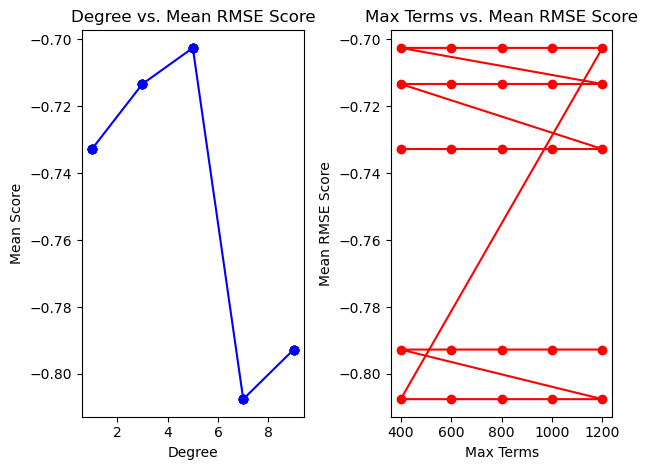

In [7]:
# Create a DataFrame to store the values
df = pd.DataFrame({'degree': degrees, 'max_terms': max_terms_values, 'mean_score': mean_scores})

# Group by degree and max_terms and calculate the average mean_score
df_avg = df.groupby(['degree', 'max_terms'])['mean_score'].mean().reset_index()

# Plotting degree against mean_score
plt.subplot(1, 2, 1)
plt.plot(degrees, mean_scores, 'bo-')
plt.xlabel('Degree')
plt.ylabel('Mean Score')
plt.title('Degree vs. Mean RMSE Score')

# Plotting max_terms against mean_score
plt.subplot(1, 2, 2)
plt.plot(max_terms_values, mean_scores, 'ro-')
plt.xlabel('Max Terms')
plt.ylabel('Mean RMSE Score')
plt.title('Max Terms vs. Mean RMSE Score')

plt.tight_layout()
plt.show()

In [5]:
print('Optimal degree in coarse grid search = ', opt_degree)
print('Optimal max_terms in coarse grid search = ', opt_max_terms)

Optimal degree in coarse grid search =  5
Optimal max_terms in coarse grid search =  400


In [17]:
# Defining the initial base model 
mars_init = Earth(max_terms = 400, max_degree = 5)
mars_init.fit(X_train, y_train)
print(mars_init.summary())

Earth Model
------------------------------------------------------------------------------------------------------------------------------
Basis Function                                                                                           Pruned  Coefficient  
------------------------------------------------------------------------------------------------------------------------------
(Intercept)                                                                                              No      9.45395      
h(alcohol-0.869565)                                                                                      No      -14.0118     
h(0.869565-alcohol)                                                                                      Yes     None         
volatile acidity                                                                                         No      -3.94577     
h(density-0.0213997)*h(0.869565-alcohol)                                                           

In [18]:
# Making predictions
pred = mars_init.predict(X_test)

# Rounding predictions to the nearest integer 
rounded_pred = [round(p) for p in pred]

In [24]:
print("Coarse Grid Tuning MARS Model Test RMSE:", np.sqrt(mean_squared_error(y_test, rounded_pred)))

Coarse Grid Tuning MARS Model Test RMSE: 1.5657389506359167


### Fine Grid Hyperparameter Optimization

In [95]:
# Finer grid search - Thinking that this will take around 64 minutes if I timed it right
    # 18 models here total (vs the 25 in the larger coarse grid search)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning)

# Initializing optimal parameters & best score variables
opt_degree = 1
opt_max_terms = 500
best_score = -float('inf')

# Outer loop for degree
for degree in range(4, 8): # Now focusing in around 4, 5, 6, 7
    print('Fitting models for degree = ', degree)
    # Creating a MARS model with the current degree and max_terms
    model = Earth(max_terms = 500, max_degree = degree)
    
    # Inner loop for max_terms
    for terms in range(300, 801, 50): # Now looking from 300 to 600 in steps of 50
        print('     Fitting models for degree = ', degree, 'and max_terms = ', terms)
        # Setting the current max_terms
        model.max_terms = terms
        
        # 5-fold cross validation
        scores = cross_val_score(model,
                                 X_train,
                                 y_train, 
                                 cv = 5, 
                                 scoring = 'neg_mean_squared_error')
        
        # Computing mean score
        mean_score = scores.mean()
        
        # Checking if mean score is better than the current best score
        if mean_score > best_score:
            best_score = mean_score
            opt_degree = degree
            opt_max_terms = terms
            
print("Optimal degree in fine grid search = ", degree)
print("Optimal max_terms in fine grid search = ", terms)

Fitting models for degree =  4
     Fitting models for degree =  4 and max_terms =  300
     Fitting models for degree =  4 and max_terms =  350
     Fitting models for degree =  4 and max_terms =  400
     Fitting models for degree =  4 and max_terms =  450
     Fitting models for degree =  4 and max_terms =  500
     Fitting models for degree =  4 and max_terms =  550
     Fitting models for degree =  4 and max_terms =  600
Fitting models for degree =  5
     Fitting models for degree =  5 and max_terms =  300
     Fitting models for degree =  5 and max_terms =  350
     Fitting models for degree =  5 and max_terms =  400
     Fitting models for degree =  5 and max_terms =  450
     Fitting models for degree =  5 and max_terms =  500
     Fitting models for degree =  5 and max_terms =  550
     Fitting models for degree =  5 and max_terms =  600
Fitting models for degree =  6
     Fitting models for degree =  6 and max_terms =  300
     Fitting models for degree =  6 and max_terms = 

In [96]:
# Defining the initial base model 
mars_model = Earth(max_terms = 600, max_degree = 6)
mars_model.fit(X_train, y_train)

Earth(max_degree=6, max_terms=600)

In [100]:
# Making predictions
pred_opt = mars_model.predict(X_test)

# Rounding predictions to the nearest integer 
rounded_pred_opt = [round(p) for p in pred_opt]

In [101]:
# Printing the test RMSE of the fine grid tuning model
print("Fine Grid Tuning MARS Model Test RMSE:", np.sqrt(mean_squared_error(y_test, rounded_pred_opt)))

Fine Grid Tuning MARS Model Test RMSE: 0.7922703501282297


### Plotting Residuals & Actual vs Predicted Values

In [102]:
# Converting rounded_pred_opt to a df
rounded_pred_opt = pd.Series(rounded_pred_opt, name='quality')
rounded_pred_opt = rounded_pred_opt.to_frame().rename(columns={'quality': 'quality'})


# Calculate residuals
residuals = y_test - rounded_pred_opt

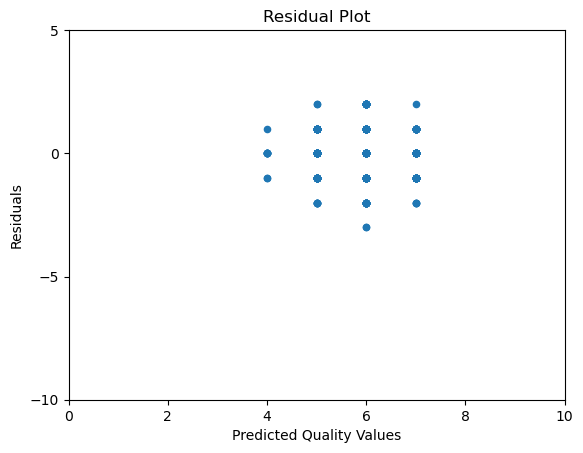

In [103]:
# Plotting residuals 
df = pd.concat([rounded_pred_opt, residuals], axis=1)
df.columns = ['quality', 'residuals']

# Jittering the points
jitter_amount = 0.2
df['jittered_residuals'] = df['residuals'] + np.random.uniform(low=-jitter_amount, high=jitter_amount, size=len(df))

# Plotting the points
residual_mars_plt = df.plot(x='quality', y='jittered_residuals', kind='scatter')
residual_mars_plt.axhline(y=0, color='red', linestyle='--')  # Add line y = 0
residual_mars_plt.set_xlabel('Predicted Quality Values')
residual_mars_plt.set_ylabel('Residuals')
residual_mars_plt.set_title('Residual Plot')
residual_mars_plt.set_xlim([0, 10])
residual_mars_plt.set_ylim([-10, 5])
residual_mars_plt.set_yticks([-10, -5, 0, 5])

# Saving the PNG
residual_mars_plt.get_figure().savefig('residual_plot_MARS.png', dpi = 300)

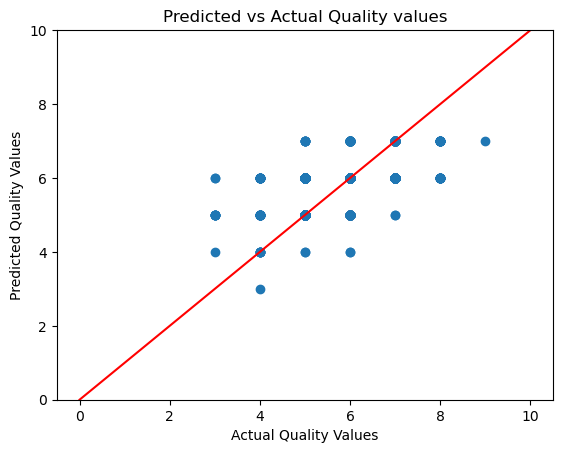

In [74]:
# Plotting predicted vs actual y values
plt.scatter(y_test, rounded_pred_opt)
plt.xlabel('Actual Quality Values')
plt.ylabel('Predicted Quality Values')
plt.title('Predicted vs Actual Quality values')
plt.ylim([0, 10])
plt.plot([0, 10], [0, 10], color='red')
plt.show()

### Creating a Model to Predict Residuals

In [104]:
# Fit a MARS model to predict residuals
residual_model = Earth()
residual_model.fit(rounded_pred_opt, residuals)

# Make predictions on test set
residuals_pred = residual_model.predict(rounded_pred_opt)

# Calculate overall RMSE of the residual model
residual_model_rmse = np.sqrt(mean_squared_error(residuals, residuals_pred))

print("RMSE of Residual Model: {:.2f}".format(residual_model_rmse))

RMSE of Residual Model: 0.75


### Finalizing the Model & Predictions

In [105]:
# Making predictions using the optimized MARS model and the residuals model as well
    # Optimized MARS model predictions held in 'rounded_pred_opt'

# Making predictions with the residuals model
residuals_pred_unrounded = residual_model.predict(rounded_pred_opt)

# Rounding predictions to the nearest integer 
residuals_pred = [round(p) for p in residuals_pred_unrounded]
residuals_pred_series = pd.Series(residuals_pred, name='quality') # Making residuals into a series

# Add predicted residuals to y_pred to get final predictions
y_pred_final = pd.concat([rounded_pred_opt, residuals_pred_series], axis=1).sum(axis=1)

# Calculating the final MARS model RMSE 
print("Test RMSE of Fine Grid MARS Model & Residuals Model:", np.sqrt(mean_squared_error(y_test, y_pred_final)))

Test RMSE of Fine Grid MARS Model & Residuals Model: 0.7620821679905854
